# 2D Unsteady Heat Equation DEMO code

This notebook demonstrates solving Unsteady 2D Fourier's Heat Equation using PINNs.

In [1]:
import deepflow as df
print("Deepflow is runned on:", df.device) # to change to cpu use df.device = 'cpu'
df.manual_seed(69) # for reproducibility

Deepflow is runned on: cuda


## 1. Define Geometry Domain
Set up the computational domain

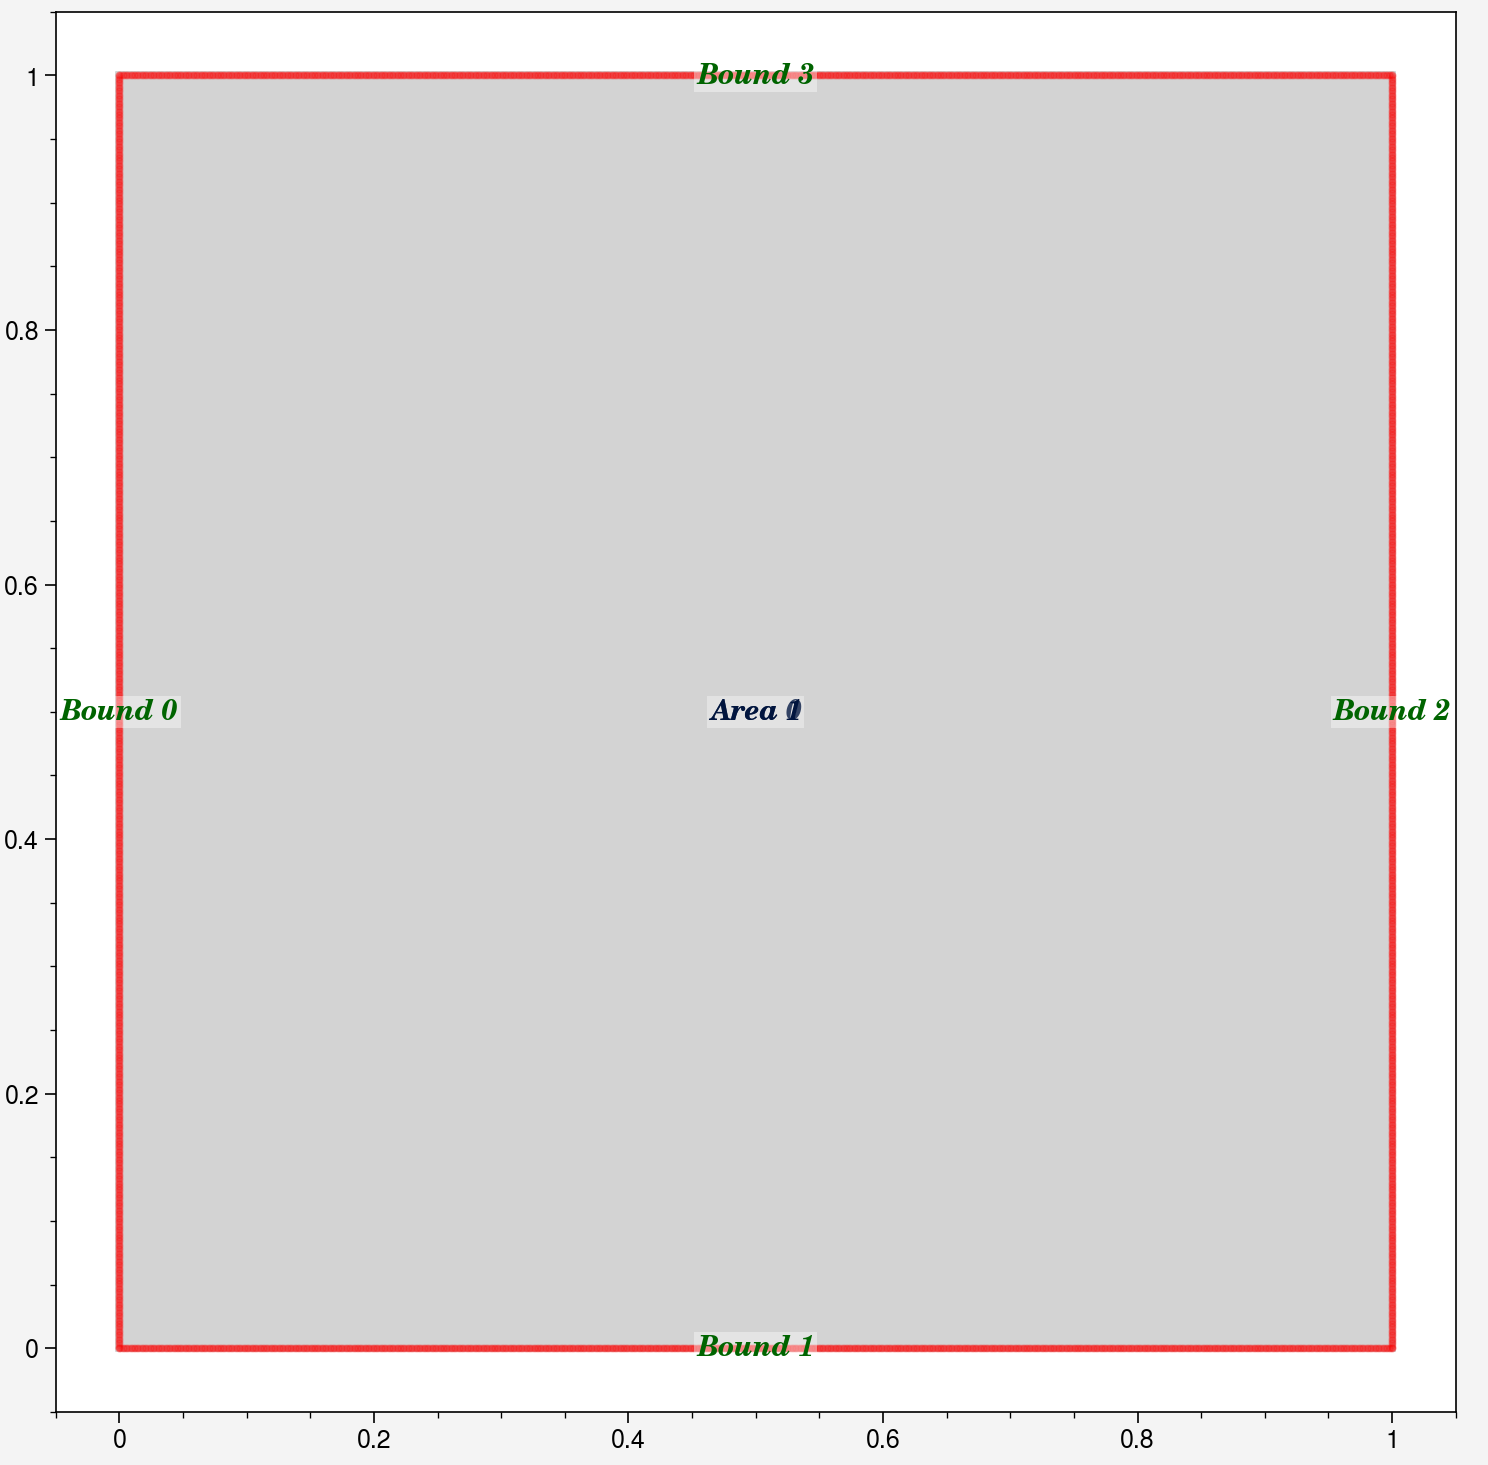

In [2]:
rectangle = df.geometry.rectangle([0, 1], [0, 1])
rectangle1 = df.geometry.rectangle([0, 1], [0, 1])
domain = df.domain(rectangle, rectangle1.area_list)
domain.show_setup()

## 2. Define Physics
Define the Burgers eq (spatial version) apply boundary conditions.

C:\Users\thamm\OneDrive\Documents\1 - Projects\0 - STEM\2 - Numerical Physics\9 - PINNs\deepflow\src\deepflow\physicsinformed.py:122: UserWarning: expo_scaling has not yet defined. False is set as default.
  warnings.warn("expo_scaling has not yet defined. False is set as default.")


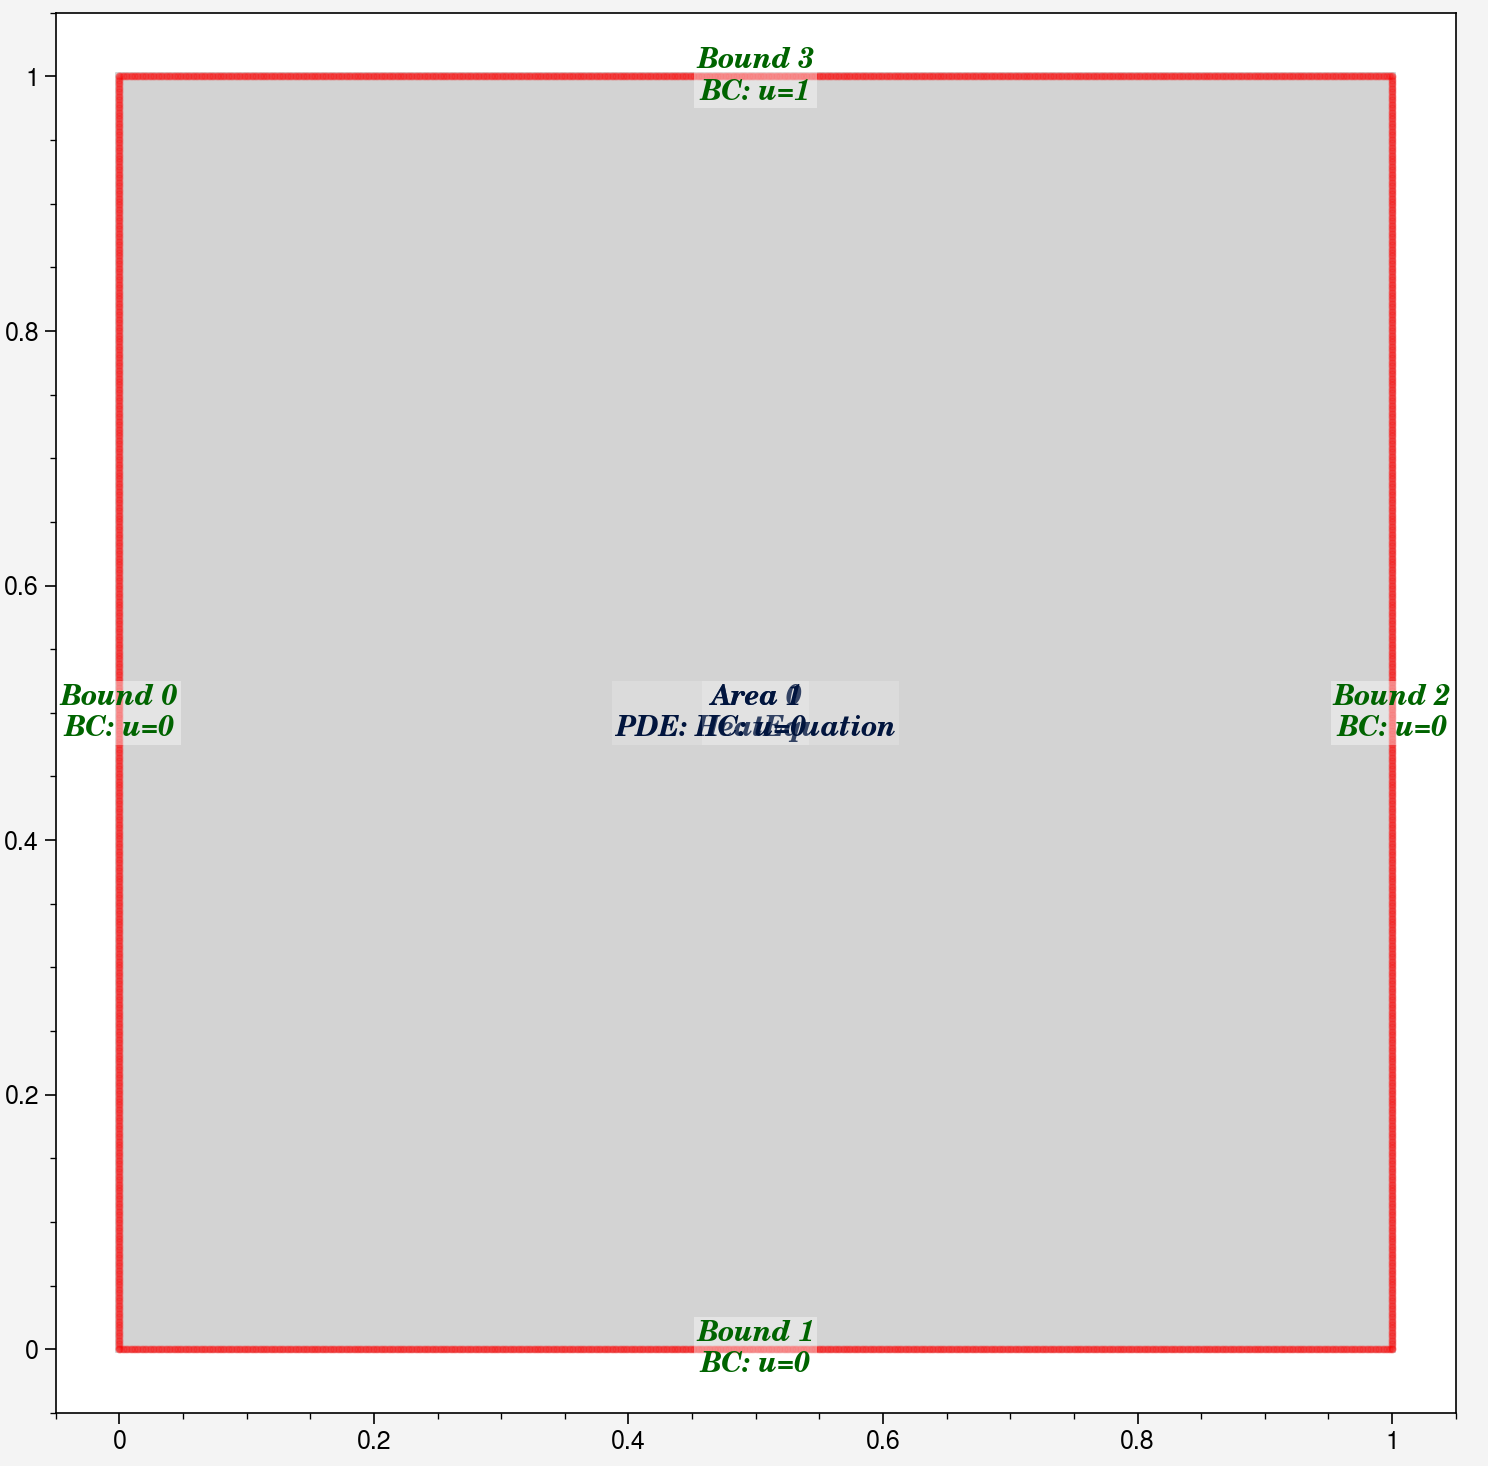

In [3]:
# Define Boundary Conditions
domain.bound_list[0].define_bc({'u': 0})   # Inflow: u=1
domain.bound_list[1].define_bc({'u': 0})   # Inflow: u=1
domain.bound_list[2].define_bc({'u': 0})   # Inflow: u=1
domain.bound_list[3].define_bc({'u': 1})  # Wall: No slip

# Define PDE (Heat Equation) and Initial Condition
domain.area_list[0].define_pde(df.pde.HeatEquation(0.1))
domain.area_list[1].define_ic({'u': 0})

# Define time domain
for g in domain:
    g.define_time(range_t = [0, 1], sampling_scheme='random')

domain.show_setup()

### 2. Generate Training Data

Sample initial points for training. After sampling, Deepflow will automatically generate training datasets based on the defined physics.

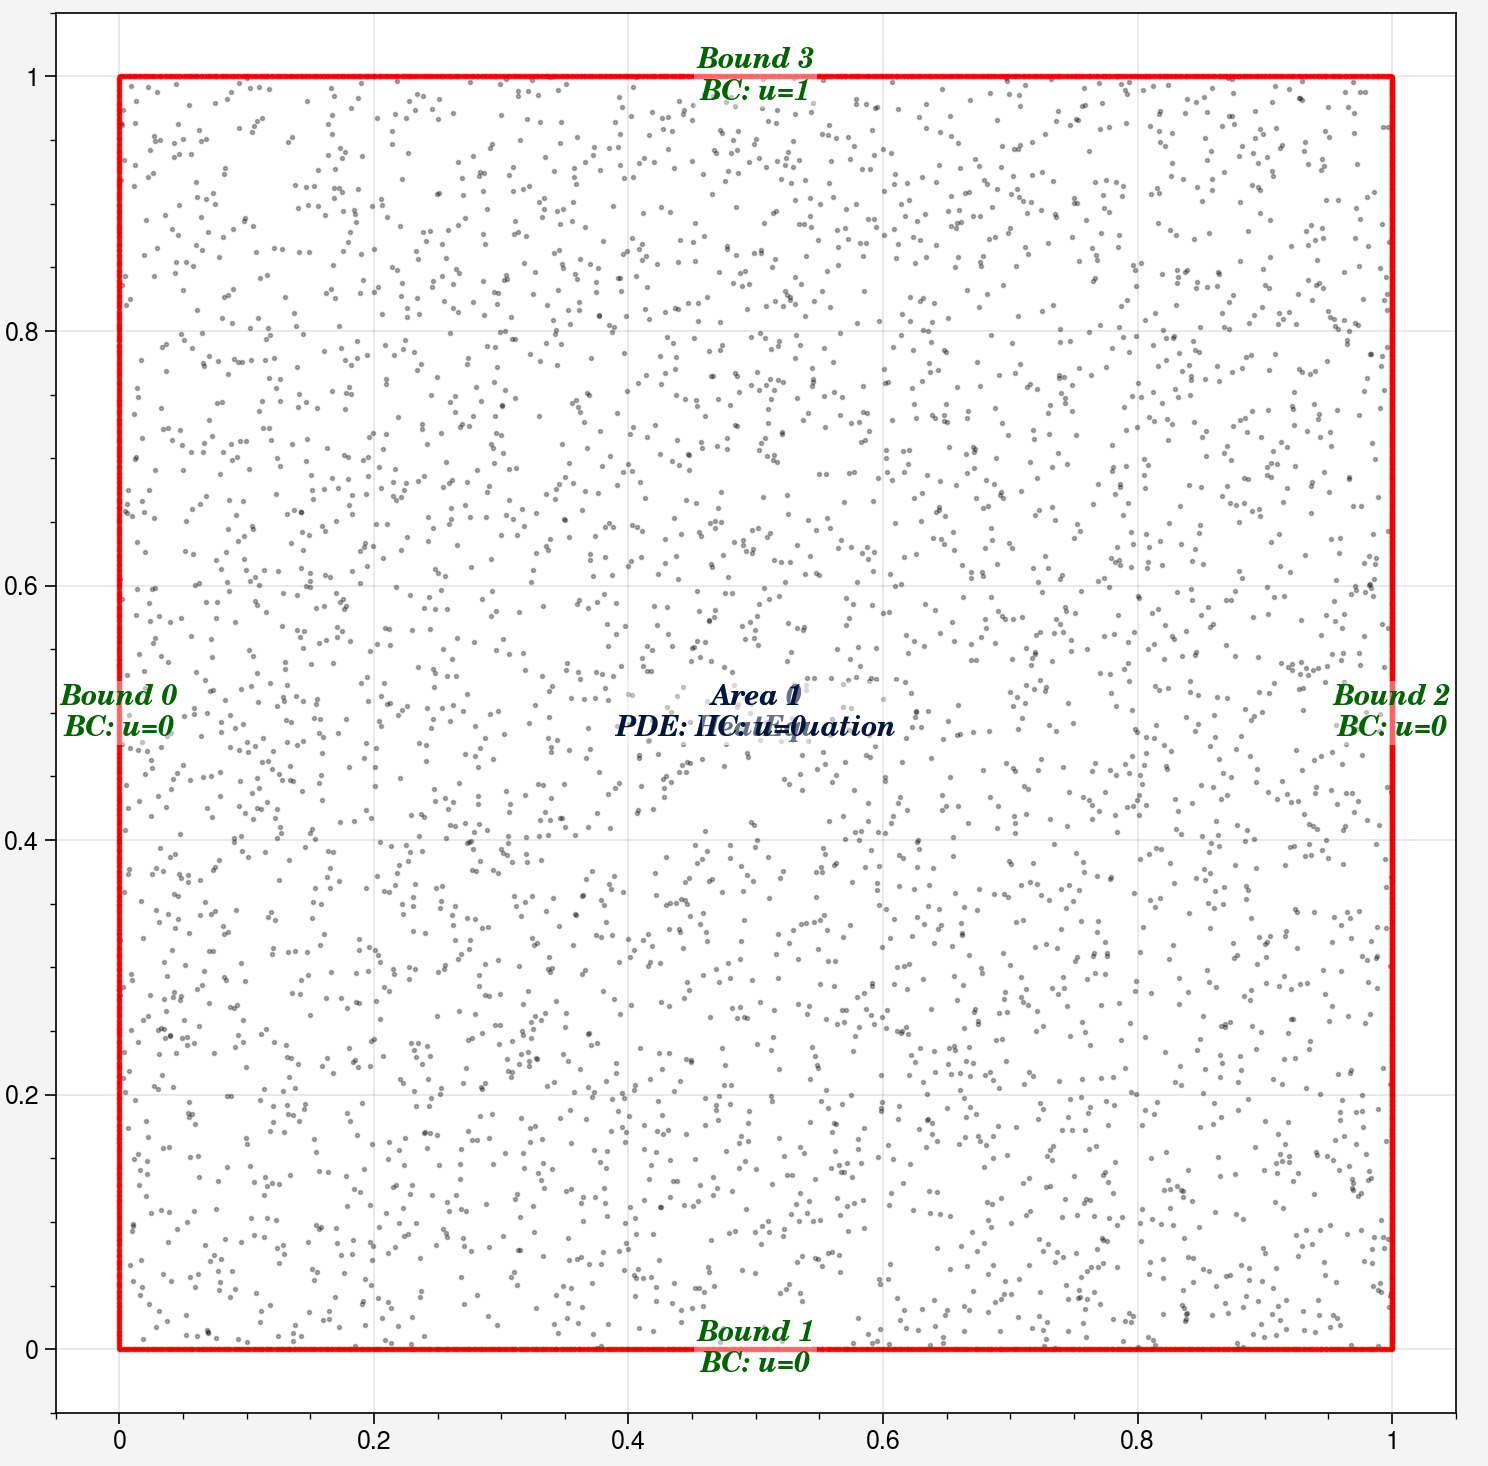

In [4]:
# Sample points: [Left, Bottom, Right, Top], [Interior]
domain.sampling_lhs([1000, 1000, 2000, 1000], [2000, 2000])
domain.show_coordinates(display_physics=True)

### 3. Train the Model

Define the resampling scheme during training. [R3](https://arxiv.org/abs/2207.02338) scheme is recommended.

In [5]:
def do_in_adam(epoch, model):
    if epoch % 1000 == 0 and epoch > 0:
        domain.sampling_R3([1000, 1000, 2000, 1000], [2000, 2000])
        print(domain)
        
def do_in_lbfgs(epoch, model):
    if epoch % 100 == 0 and epoch > 0:
        domain.sampling_R3([1000, 1000, 2000, 1000], [2000, 2000])
        print(domain)

Train the model using Adam optimizer followed by L-BFGS optimizer.

In [6]:
model0 = df.PINN(width=32, length=4, input_vars=['x','y','t'], output_vars=['u'])
model1, model1_best = model0.train_adam(
    calc_loss = df.calc_loss_simple(domain),
    learning_rate=0.004,
    do_between_epochs=do_in_adam,
    epochs=2000)

Epoch: 1, total_loss: 1.07443, bc_loss: 1.07223, pde_loss: 0.00057, ic_loss: 0.00163
Epoch: 200, total_loss: 0.14737, bc_loss: 0.10960, pde_loss: 0.00755, ic_loss: 0.03022
Epoch: 400, total_loss: 0.12092, bc_loss: 0.09239, pde_loss: 0.00619, ic_loss: 0.02235
Epoch: 600, total_loss: 0.10623, bc_loss: 0.08636, pde_loss: 0.00744, ic_loss: 0.01244
Epoch: 800, total_loss: 0.06537, bc_loss: 0.04880, pde_loss: 0.00647, ic_loss: 0.01010
Epoch: 1000, total_loss: 0.05430, bc_loss: 0.03624, pde_loss: 0.00955, ic_loss: 0.00850
number of bound : ['0: 1321', '1: 1590', '2: 2388', '3: 1253']
number of area : ['0: 2550', '1: 2429']
Epoch: 1200, total_loss: 0.06119, bc_loss: 0.04864, pde_loss: 0.00576, ic_loss: 0.00679
Epoch: 1400, total_loss: 0.09882, bc_loss: 0.07925, pde_loss: 0.00781, ic_loss: 0.01176
Epoch: 1600, total_loss: 0.05544, bc_loss: 0.04448, pde_loss: 0.00462, ic_loss: 0.00634
Epoch: 1800, total_loss: 0.05426, bc_loss: 0.03893, pde_loss: 0.00863, ic_loss: 0.00671
Epoch: 2000, total_loss:

In [8]:
model2 = model1_best.train_lbfgs(calc_loss = df.calc_loss_simple(domain), epochs=450, do_between_epochs=do_in_lbfgs, threshold_loss=5e-3)

Epoch: 2000, total_loss: 0.05703, bc_loss: 0.04316, pde_loss: 0.00694, ic_loss: 0.00693
Epoch: 2050, total_loss: 0.01069, bc_loss: 0.00796, pde_loss: 0.00205, ic_loss: 0.00068
Training interrupted by user.


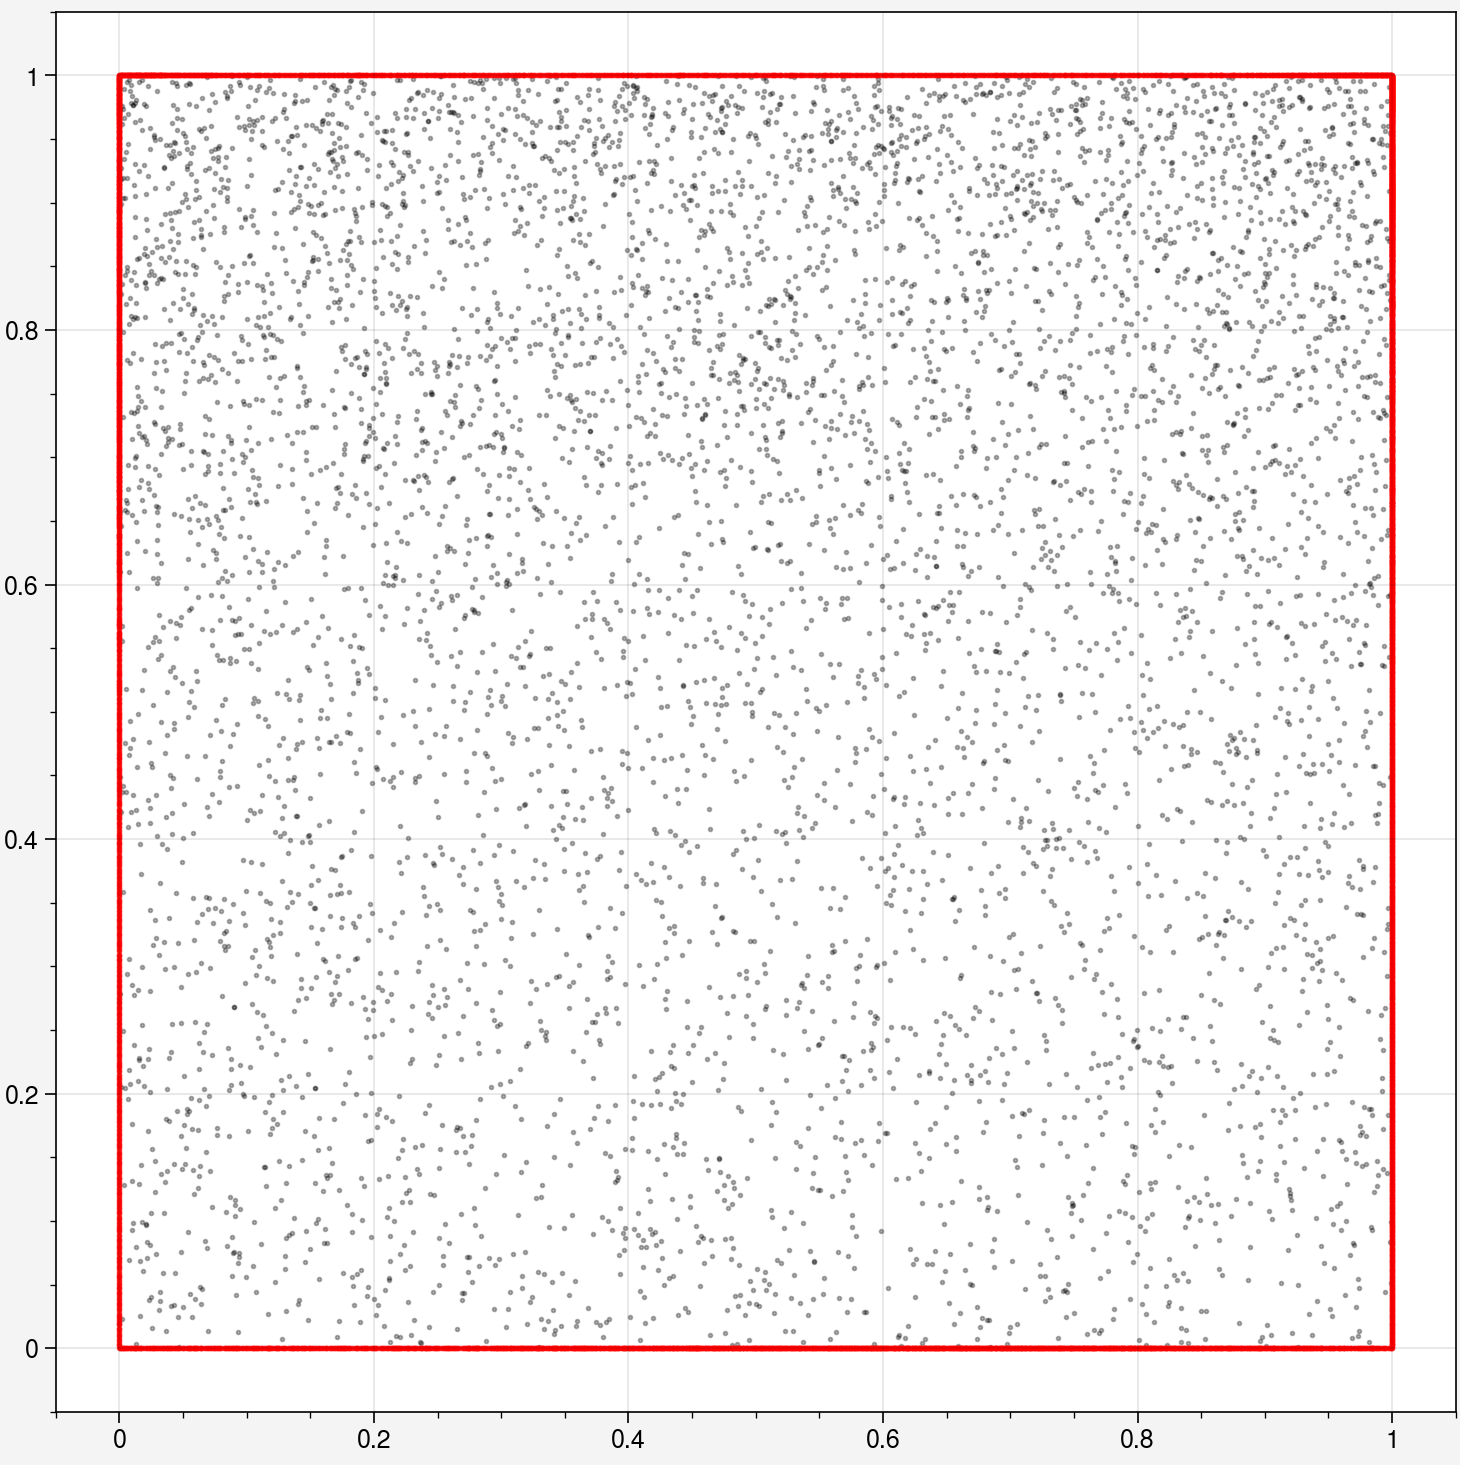

In [9]:
domain.show_coordinates(display_physics=False)

## 4. Visualization

In [10]:
# Evaluate the best model
prediction = domain.area_list[0].evaluate(model2)
prediction.sampling_area([200, 200])
prediction.define_time(0.5)

### 4.1 Visualize PDE area

C:\Users\thamm\AppData\Local\Temp\ipykernel_15656\1618917411.py:3: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  _.savefig('heat_eq_u.png', dpi=200)
C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\events.py:82: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  func(*args, **kwargs)
C:\Users\thamm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UltraPlotWarning: Tick label sharing not implemented for <class 'ultraplot.axes.three.ThreeAxes'> subplots.
  fig.canvas.print_figure(bytes_io, **kw)


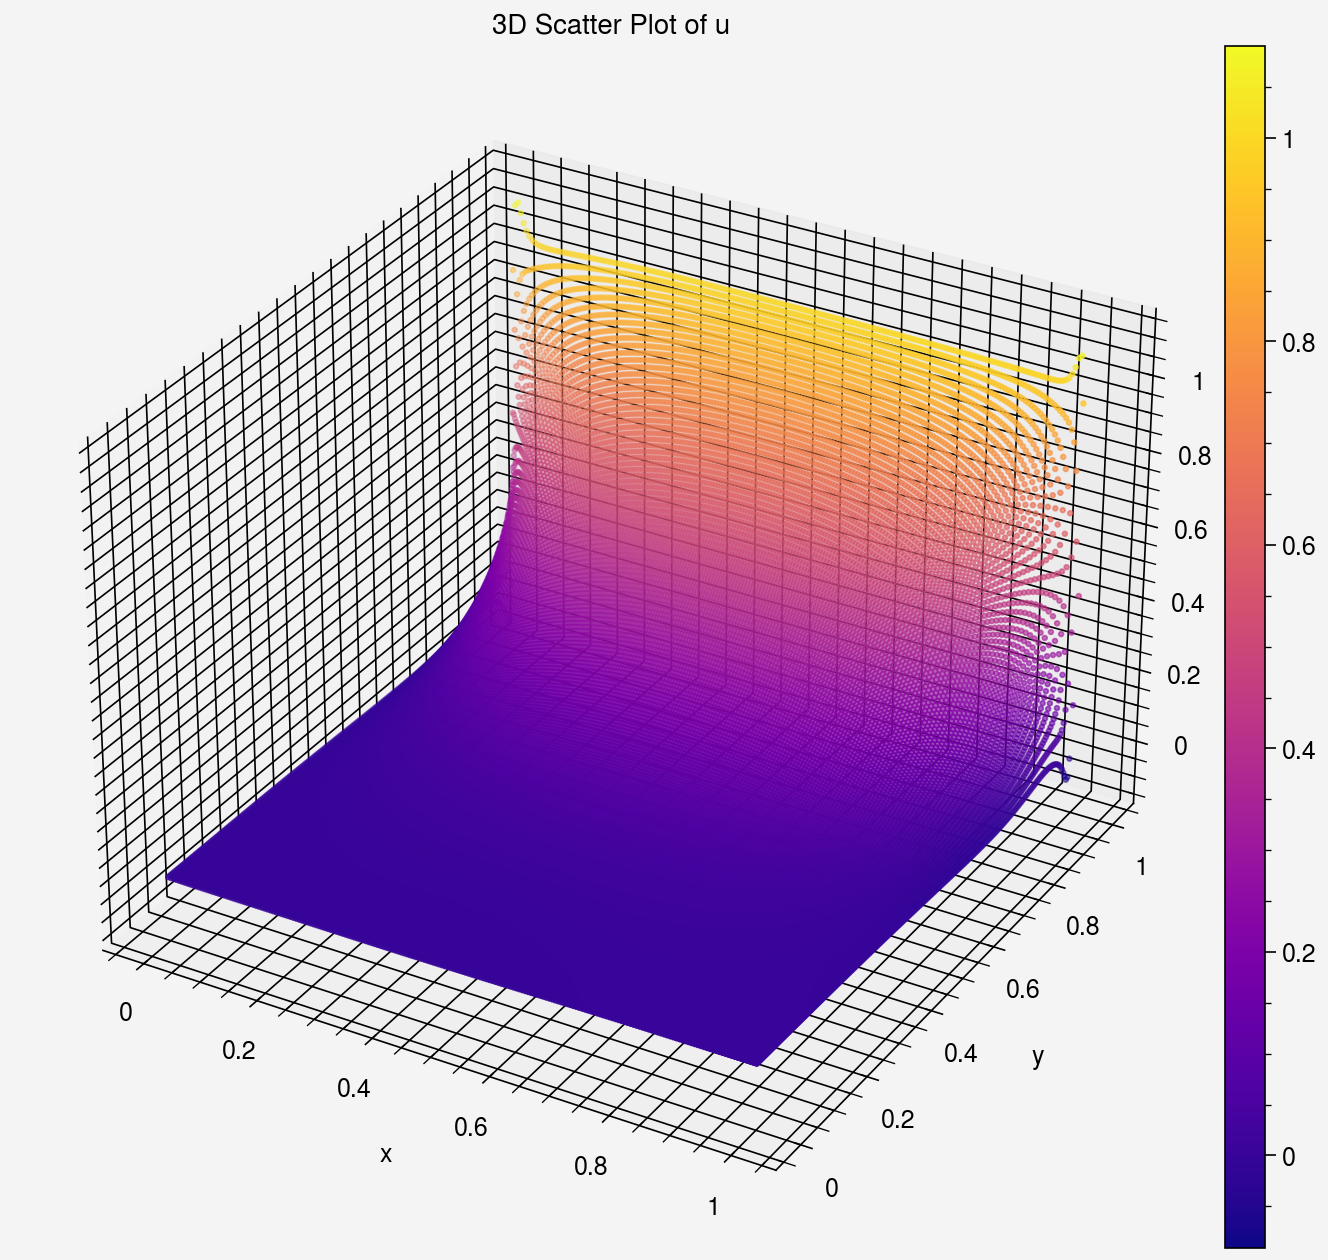

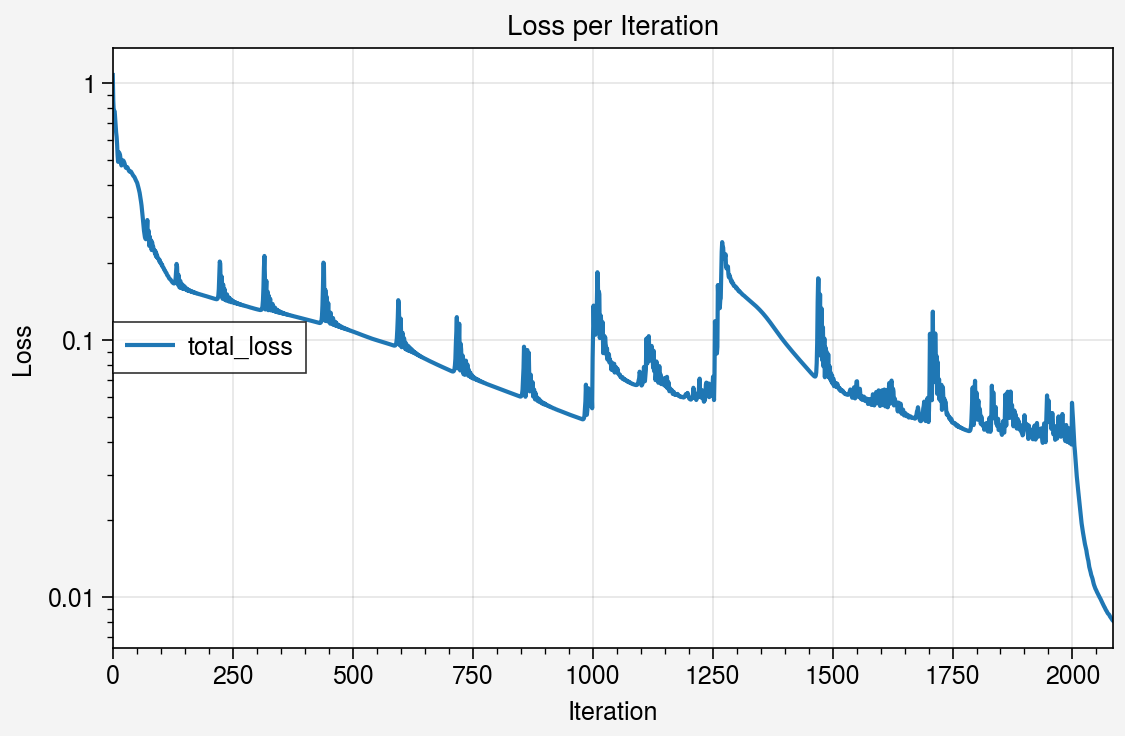

In [11]:
# Plot Temperature Field
_ = prediction.plot('u', color='plasma')
_.savefig('heat_eq_u.png', dpi=200)

# Plot Training Loss
_ =prediction.plot_loss_curve(log_scale=True, keys=['total_loss'])

## 4.2 Animate the solution over time

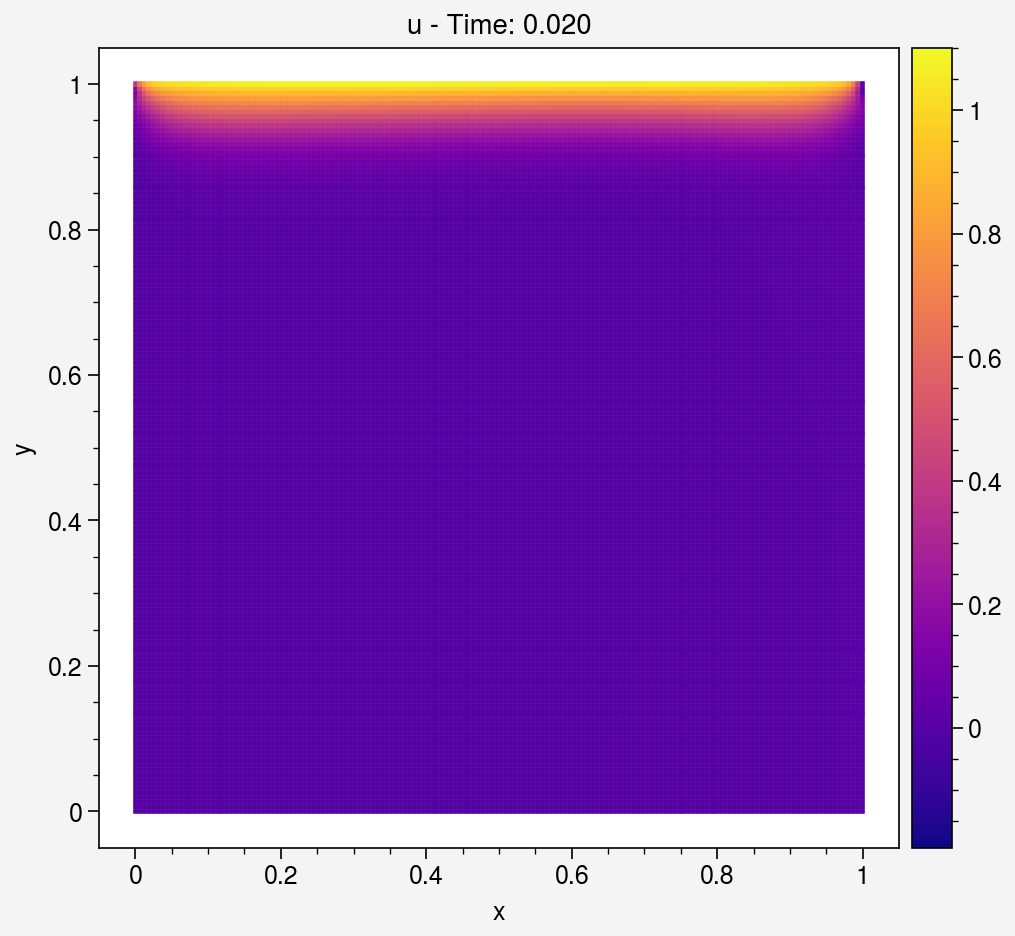

In [14]:
prediction.sampling_area([160, 160])
prediction.plot_animate('u', range_t = [0.02, 1.02], dt = 0.02, frame_interval=100, cmap='plasma', plot_type='scatter', s=1.7).save('heat_equation.mp4', dpi = 200)